<a href="https://colab.research.google.com/github/Mojtaba1996-glitch/Automated-Token-Release-Schedule-System/blob/main/project_decemebr_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt # Import the matplotlib.pyplot module and assign it the alias 'plt'
import pandas as pd


In [ ]:


def Moji_dailly(segments, max_supply, start_date):
    import pandas as pd

    all_schedules = []

    # Determine the maximum end date across all segments
    max_days = max(
        (x['lockup_months'] + x['linear_release_months']) * 30 for x in segments
    )
    master_dates = pd.date_range(start=start_date, periods=max_days).date


    for x in segments:
        name = x['name']
        percent_max_supply = x['percent_max_supply']
        tge_percentage = x['tge_percentage']
        lockup_months = x['lockup_months']
        linear_release_months = x['linear_release_months']

        total_tokens = percent_max_supply * max_supply
        tokens_at_tge = tge_percentage * total_tokens
        remained_tokens = total_tokens - tokens_at_tge

        lockup_days = lockup_months * 30
        linear_release_days = linear_release_months * 30
        total_days = lockup_days + linear_release_days

        daily_release = remained_tokens / linear_release_days if linear_release_days > 0 else 0

        # Initialize release schedules
        daily_release_schedule = []
        cumulative_release_schedule = []

        for day in range(total_days):
            if day < lockup_days:
                daily_release_schedule.append(0)
                if not cumulative_release_schedule:
                    cumulative_release_schedule.append(tokens_at_tge)
                else:
                    cumulative_release_schedule.append(cumulative_release_schedule[-1])
            else:
                tokens_released_today = daily_release
                if not cumulative_release_schedule:
                    cumulative_tokens = tokens_at_tge + tokens_released_today
                else:
                    cumulative_tokens = cumulative_release_schedule[-1] + daily_release
                if cumulative_tokens > total_tokens:
                    cumulative_tokens = total_tokens  # Cap at total tokens
                daily_release_schedule.append(tokens_released_today)
                cumulative_release_schedule.append(cumulative_tokens)

        # Pad remaining cells with the maximum value
        while len(cumulative_release_schedule) < len(master_dates):
            cumulative_release_schedule.append(total_tokens)
            daily_release_schedule.append(0)

        # Create a DataFrame for this segment
        segment_schedule = pd.DataFrame({
            f'{name}(Cumulative)': cumulative_release_schedule,
            f'{name}(Daily)': daily_release_schedule
        }, index=master_dates)

        all_schedules.append(segment_schedule)

    # Combine all segment schedules
    combined_schedule = pd.concat(all_schedules, axis=1)
    combined_schedule.index.name = 'Date'

    # Add a new column for the total cumulative tokens
    cumulative_columns = [col for col in combined_schedule.columns if '(Cumulative)' in col]
    combined_schedule['Total Cumulative'] = combined_schedule[cumulative_columns].sum(axis=1)
    daily_columns = [col for col in combined_schedule.columns if '(Daily)' in col]
    combined_schedule['Total Daily'] = combined_schedule[daily_columns].sum(axis=1)

    return combined_schedule




#----------------------------------------------------------------------------------------
def get_token_details():
    print("Enter token details. Type 'done' when finished.")
    token_details = {}

    # Token Name
    token_name = input("Token Name (e.g., 'TrustPay Coin'): ")
    token_details["Token Name"] = token_name

    # Token Symbol
    symbol = input("Symbol (e.g., 'TXP'): ")
    token_details["Symbol"] = symbol

    # Protocol
    protocol = input("Protocol (e.g., 'Ethereum'): ")
    token_details["Protocol"] = protocol

    # Starting Price
    while True:
        try:
            starting_price = float(input("Starting Price (e.g., $0.120): ").strip().replace("$", ""))
            token_details["Starting Price"] = f"${starting_price:.3f}"
            break
        except ValueError:
            print("Invalid input. Please enter a valid numeric price.")

    # Max Supply
    while True:
        try:
            max_supply = int(input("Max Supply (e.g., 500000000): ").strip())
            token_details["Max Supply"] = max_supply
            break
        except ValueError:
            print("Invalid input. Please enter a valid numeric value for Max Supply.")

    print("Token details successfully created:")
    for key, value in token_details.items():
        print(f"{key}: {value}")

    return token_details


#-------------------------------------------------------------------------------------------------------------

def get_token_price_table(max_supply):
    """
    Collects data for the Token Price table from the user and calculates necessary fields.

    Args:
        max_supply (int): The maximum token supply.

    Returns:
        pd.DataFrame: A DataFrame representing the Token Price table.
    """
    print("Enter Token Price table details. Type 'done' when finished.")
    token_price_data = []

    # Get the public price first, as it's required to calculate discounts
    while True:
        try:
            public_price = float(input("Enter the public price (e.g., 0.120): ").strip().replace("$", ""))
            break
        except ValueError:
            print("Invalid input. Please enter a valid numeric public price.")

    while True:
        round_name = input("Round Name (or type 'done' to finish): ")
        if round_name.lower() == 'done':
            break

        # Get percentage of max supply
        while True:
            try:
                percent_max_supply = float(input(f"Percentage of Max Supply for {round_name} (e.g., 0.04): "))
                break
            except ValueError:
                print("Invalid input. Please enter a valid percentage.")

        # Get price for the round
        while True:
            try:
                price = float(input(f"Price for {round_name} (e.g., 0.030): ").strip().replace("$", ""))  # Remove $ sign here
                break
            except ValueError:
                print("Invalid input. Please enter a valid numeric price.")

        # Calculate derived fields
        tokens = percent_max_supply * max_supply
        discount = (public_price - price) / public_price if public_price > 0 else 0
        funding = tokens * price

        # Add row to the table
        token_price_data.append({
            "Round": round_name,
            "Tokens": int(tokens),
            "% Max Supply": f"{percent_max_supply:.2%}",
            "Price": price,  # Store as numeric price here (no $ sign)
            "Discount": f"{discount:.2%}",
            "Funding": f"${funding:,.2f}"
        })

    # Convert to a DataFrame
    token_price_df = pd.DataFrame(token_price_data)
    print("Token Price table successfully created:")
    print(token_price_df)
    return token_price_df

#-----------------------------------------------------------------

def calculate_total_tge_release(segments, max_supply):
    """
    Calculate the total TGE release from all segments.

    Args:
        segments (list of dict): Segment data including TGE percentages.
        max_supply (int): Maximum supply of tokens.

    Returns:
        float: Total tokens released at TGE.
    """
    total_tge_release = sum(
        x['tge_percentage'] * (x['percent_max_supply'] * max_supply)
        for x in segments
    )
    return total_tge_release


def calculate_capitalisation(token_price_df, max_supply, segments):
    """
    Calculate the Capitalisation table based on the Token Price table.

    Args:
        token_price_df (pd.DataFrame): The Token Price DataFrame.
        max_supply (int): The maximum supply of tokens.
        segments (list of dict): Segment data to calculate total TGE release.

    Returns:
        pd.DataFrame: A new DataFrame with Capitalisation columns (Pre-Launch, Launch, FDV).
    """
    if isinstance(token_price_df, list):
        token_price_df = pd.DataFrame(token_price_df)
    # Ensure that 'Price' and 'Tokens' columns are numeric
    token_price_df["Price"] = pd.to_numeric(token_price_df["Price"], errors='coerce')
    token_price_df["Tokens"] = pd.to_numeric(token_price_df["Tokens"], errors='coerce')

    # Calculate total TGE release
    total_tge_release = calculate_total_tge_release(segments, max_supply)

    # Add cumulative tokens for Pre-Launch calculation
    token_price_df["Cumulative Tokens"] = token_price_df["Tokens"].cumsum()

    # Calculate Pre-Launch column
    token_price_df["Pre-Launch"] = token_price_df.apply(
        lambda row: row["Price"] * row["Cumulative Tokens"] if pd.notnull(row["Price"]) and pd.notnull(row["Cumulative Tokens"]) else 0,
        axis=1
    )

    # Calculate Launch column using total TGE release
    token_price_df["Launch"] = token_price_df["Price"] * total_tge_release

    # Calculate FDV column
    token_price_df["FDV"] = token_price_df["Price"] * max_supply

    # Extract Capitalisation columns into a new DataFrame
    capitalisation_df = token_price_df[["Round", "Pre-Launch", "Launch", "FDV"]]

    token_price_df.drop(columns=["Cumulative Tokens"], inplace=True)  # Drop the cumulative tokens column
    token_price_df.drop(columns=["Pre-Launch", "Launch", "FDV"], inplace=True)  # Drop the original columns

    print("Capitalisation table successfully created:")
    print(capitalisation_df)

    return capitalisation_df



In [ ]:
!pip install openpyxl

In [ ]:
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.cell.cell import MergedCell
from openpyxl import Workbook # Import Workbook class
from openpyxl.utils import get_column_letter # Import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows # Import dataframe_to_rows
from openpyxl.styles import Font, Alignment, PatternFill



def export_with_token_details_and_price(schedule_df, token_details, token_price_df, capitalisation_df, output_file, segments, max_supply, start_date):
    """
    Export the token release schedule, token details, token price table, capitalisation table, and token distribution table to an Excel file.
    """
    # Ensure output directory exists
    # output_file = Path(output_file)
    # output_file.parent.mkdir(parents=True, exist_ok=True)

    # Create a new workbook and get the active worksheet
    wb = Workbook()
    ws = wb.active
    ws.title = "Token Model"

    # Add Token Details
    ws.merge_cells("A1:B1")
    ws["A1"].value = "Token Details"
    ws["A1"].font = Font(bold=True, size=14, color="FFFFFF")
    ws["A1"].alignment = Alignment(horizontal="center", vertical="center")
    ws["A1"].fill = PatternFill(start_color="23395D", end_color="23395D", fill_type="solid")

    for row_idx, (key, value) in enumerate(token_details.items(), start=2):
        ws[f"A{row_idx}"].value = key
        ws[f"A{row_idx}"].font = Font(bold=True)
        ws[f"A{row_idx}"].alignment = Alignment(horizontal="right")
        ws[f"B{row_idx}"].value = value

    # Add Token Price Table
    start_col = 4  # Column where the Token Price Table starts
    ws.merge_cells(start_row=1, start_column=start_col, end_row=1, end_column=start_col + len(token_price_df.columns) - 1)
    ws.cell(row=1, column=start_col).value = "Token Price"
    ws.cell(row=1, column=start_col).font = Font(bold=True, size=14, color="FFFFFF")
    ws.cell(row=1, column=start_col).alignment = Alignment(horizontal="center")
    ws.cell(row=1, column=start_col).fill = PatternFill(start_color="23395D", end_color="23395D", fill_type="solid")

    for r_idx, row in enumerate(dataframe_to_rows(token_price_df, index=False, header=True), start=2):
        for c_idx, value in enumerate(row, start=start_col):
            ws.cell(row=r_idx, column=c_idx).value = value

    # Add Capitalisation Table next to the Token Price Table
    cap_start_col = start_col + len(token_price_df.columns) + 2  # Start Capitalisation Table after Token Price Table
    ws.merge_cells(start_row=1, start_column=cap_start_col, end_row=1, end_column=cap_start_col + len(capitalisation_df.columns) - 1)
    ws.cell(row=1, column=cap_start_col).value = "Capitalisation Table"
    ws.cell(row=1, column=cap_start_col).font = Font(bold=True, size=14, color="FFFFFF")
    ws.cell(row=1, column=cap_start_col).alignment = Alignment(horizontal="center")
    ws.cell(row=1, column=cap_start_col).fill = PatternFill(start_color="23395D", end_color="23395D", fill_type="solid")

    for r_idx, row in enumerate(dataframe_to_rows(capitalisation_df, index=False, header=True), start=2):
        for c_idx, value in enumerate(row, start=cap_start_col):
            ws.cell(row=r_idx, column=c_idx).value = value

    # Add Token Distribution Table
    dist_start_row = max(len(token_details) + 3, len(token_price_df) + 3, len(capitalisation_df) + 3)
    ws.merge_cells(start_row=dist_start_row, start_column=1, end_row=dist_start_row, end_column=5)
    ws.cell(row=dist_start_row, column=1).value = "Token Distribution"
    ws.cell(row=dist_start_row, column=1).font = Font(bold=True, size=14, color="FFFFFF")
    ws.cell(row=dist_start_row, column=1).alignment = Alignment(horizontal="center")
    ws.cell(row=dist_start_row, column=1).fill = PatternFill(start_color="23395D", end_color="23395D", fill_type="solid")

    # Define header for the Token Distribution Table
    ws.cell(row=dist_start_row + 1, column=1).value = "Segment"
    ws.cell(row=dist_start_row + 1, column=2).value = "Tokens"
    ws.cell(row=dist_start_row + 1, column=3).value = "% Max Supply"
    ws.cell(row=dist_start_row + 1, column=4).value = "% on TGE"
    ws.cell(row=dist_start_row + 1, column=5).value = "Token on TGE" #added
    ws.cell(row=dist_start_row + 1, column=6).value = "Lockup"
    ws.cell(row=dist_start_row + 1, column=7).value = "Linear Release"

    # Add the data for each segment
    row_idx = dist_start_row + 2
    for segment in segments:
        name = segment['name']
        percent_max_supply = segment['percent_max_supply']
        total_tokens = percent_max_supply * max_supply
        tge_percentage = segment['tge_percentage']
        tokens_on_tge = tge_percentage * total_tokens
        lockup_months = segment['lockup_months']
        linear_release_months = segment['linear_release_months']
        lockup_linear_release_months = linear_release_months

        ws.cell(row=row_idx, column=1).value = name
        ws.cell(row=row_idx, column=2).value = total_tokens
        ws.cell(row=row_idx, column=3).value = percent_max_supply
        ws.cell(row=row_idx, column=4).value = tge_percentage
        ws.cell(row=row_idx, column=5).value = tokens_on_tge #added
        ws.cell(row=row_idx, column=6).value = lockup_months
        ws.cell(row=row_idx, column=7).value = lockup_linear_release_months

        row_idx += 1

    # Add Token Release Schedule (below all tables)
    schedule_start_row = dist_start_row + len(segments) + 3
    ws.merge_cells(start_row=schedule_start_row, start_column=1, end_row=schedule_start_row, end_column=len(schedule_df.columns))
    ws.cell(row=schedule_start_row, column=1).value = "Token Release Schedule"
    ws.cell(row=schedule_start_row, column=1).font = Font(bold=True, size=14)
    ws.cell(row=schedule_start_row, column=1).alignment = Alignment(horizontal="center")

    schedule_df_reset = schedule_df.reset_index()
    for r_idx, row in enumerate(dataframe_to_rows(schedule_df_reset, index=False, header=True), start=schedule_start_row + 1):
        for c_idx, value in enumerate(row, start=1):
            ws.cell(row=r_idx, column=c_idx).value = value

    # Auto-adjust column widths
    for col in ws.columns:
        max_length = 0
        col_letter = get_column_letter(col[0].column)
        for cell in col:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))
        ws.column_dimensions[col_letter].width = max_length + 2

    # Save the workbook
    wb.save(output_file)
    print(f"Report saved to {output_file}")




In [ ]:
# # Set the max supply and start date
# max_supply = 500_000_000  # Example max supply
# start_date = '2025-01-01'  # Example start date (YYYY-MM-DD)

# if __name__ == "__main__":
#     # Get Token Details
#     TOKEN_DETAILS = get_token_details()

#     # Get Segments
#     # segments = get_segments()

#     segments = [

#     {'name': 'Seed', 'percent_max_supply': 0.04, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 18},
#     {'name': 'Private', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 12},
#     {'name': 'Pre-Sale', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 4, 'linear_release_months': 12}
#      ]

#     # Define the maximum supply (example value, adjust as necessary)
#     max_supply = 500_000_000

#     # Generate Token Release Schedule
#     schedule_df = Moji_dailly(segments, max_supply=max_supply, start_date='2025-01-01')

#     # Generate Token Price Table
#     token_price_df = get_token_price_table(max_supply=max_supply)

#     # Calculate Capitalisation Table
#     capitalisation_df = calculate_capitalisation(token_price_df, max_supply=max_supply, segments=segments)

#     # # Export to Excel
#     # export_with_token_details_and_price(
#     #     schedule_df,
#     #     TOKEN_DETAILS,
#     #     token_price_df,
#     #     capitalisation_df,  # Include the Capitalisation DataFrame
#     #     output_file="token_model_report_with_price_and_capitalisation.xlsx",
#     #     segments,            # Pass segments obtained from get_segments()
#     #     max_supply,          # Pass the max supply value
#     #     start_date

#     # )
#     # Assuming schedule_df, TOKEN_DETAILS, token_price_df, and capitalisation_df are already defined in your code
#     export_with_token_details_and_price(
#     schedule_df,
#     TOKEN_DETAILS,
#     token_price_df,
#     capitalisation_df,
#     'output_file.xlsx',  # Path to save the Excel file
#     segments,            # Pass segments obtained from get_segments()
#     max_supply,          # Pass the max supply value
#     start_date           # Pass the start date
# )

In [ ]:
# # execuation phase

# import pandas as pd

# # Define the maximum supply and start date
# max_supply = 500_000_000
# start_date = '2025-01-01'

# # Predefined Token Details
# # TOKEN_DETAILS = {
# #     "Token Name": "TrustPay Coin",
# #     "Symbol": "TXP",
# #     "Protocol": "Ethereum",
# #     "Starting Price": 0.120,
# #     "Max Supply": max_supply
# # }

# # # Predefined Segments
# # segments = [
# #     {"name": "Seed", "percent_max_supply": 0.04, "tge_percentage": 0.05, "lockup_months": 6, "linear_release_months": 18},
# #     {"name": "Private", "percent_max_supply": 0.10, "tge_percentage": 0.05, "lockup_months": 6, "linear_release_months": 12},
# #     {"name": "Pre-Sale", "percent_max_supply": 0.10, "tge_percentage": 0.05, "lockup_months": 4, "linear_release_months": 12}
# # ]

# # TOKEN_DETAILS = get_token_details()

# segments = [
#     {"name": "Seed", "percent_max_supply": 0.04, "tge_percentage": 0.05, "lockup_months": 6, "linear_release_months": 18},
#     {"name": "Private", "percent_max_supply": 0.10, "tge_percentage": 0.05, "lockup_months": 6, "linear_release_months": 12},
#     {"name": "Pre-Sale", "percent_max_supply": 0.10, "tge_percentage": 0.05, "lockup_months": 4, "linear_release_months": 12},
#     {"name": "Public", "percent_max_supply": 0.10, "tge_percentage": 0.50, "lockup_months": 0, "linear_release_months": 3},
#     {"name": "Team", "percent_max_supply": 0.08, "tge_percentage": 0.00, "lockup_months": 12, "linear_release_months": 12},
#     {"name": "Advisors", "percent_max_supply": 0.02, "tge_percentage": 0.00, "lockup_months": 6, "linear_release_months": 12},
#     {"name": "Rewards", "percent_max_supply": 0.24, "tge_percentage": 0.05, "lockup_months": 1, "linear_release_months": 48},
#     {"name": "Liquidity", "percent_max_supply": 0.15, "tge_percentage": 0.20, "lockup_months": 0, "linear_release_months": 12},
#     {"name": "Treasury", "percent_max_supply": 0.10, "tge_percentage": 0.05, "lockup_months": 6, "linear_release_months": 18},
#     {"name": "Reserve", "percent_max_supply": 0.07, "tge_percentage": 0.00, "lockup_months": 6, "linear_release_months": 18},
# ]


# # # Predefined Token Price Table
# # token_price_df = [
# #     {"Round": "seed", "Percentage of Max Supply": 0.04, "Price": 0.030},
# #     {"Round": "private", "Percentage of Max Supply": 0.10, "Price": 0.60},
# #     {"Round": "pre-sale", "Percentage of Max Supply": 0.10, "Price": 0.090}
# # ]


# token_price_df = get_token_price_table(max_supply=max_supply)


# if __name__ == "__main__":
#     # Convert token_price_df to a pandas DataFrame
#     token_price_df = pd.DataFrame(token_price_df)

#     # Debug: Print column names to verify correctness
#     print("Columns in token_price_df:", token_price_df.columns)

#     # Ensure column names match exactly (remove extra spaces, if any)
#     token_price_df.columns = token_price_df.columns.str.strip()

#     # Calculate the number of tokens for each round
#     token_price_df["Tokens"] = token_price_df["Percentage of Max Supply"] * max_supply

#     # Generate Token Release Schedule
#     schedule_df = Moji_dailly(segments, max_supply=max_supply, start_date=start_date)

#     # Calculate Capitalisation Table
#     capitalisation_df = calculate_capitalisation(token_price_df, max_supply=max_supply, segments=segments)

#     # Export to Excel
#     export_with_token_details_and_price(
#         schedule_df,
#         TOKEN_DETAILS,
#         token_price_df,
#         capitalisation_df,
#         output_file="token_model_report_with_price_and_capitalisation.xlsx",
#         segments=segments,
#         max_supply=max_supply,
#         start_date=start_date
#     )


Enter token details. Type 'done' when finished.
Token Name (e.g., 'TrustPay Coin'): TrustPay Coin
Symbol (e.g., 'TXP'): TXP
Protocol (e.g., 'Ethereum'): Ethereum
Starting Price (e.g., $0.120): 0.120
Max Supply (e.g., 500000000): 500000000
Token details successfully created:
Token Name: TrustPay Coin
Symbol: TXP
Protocol: Ethereum
Starting Price: $0.120
Max Supply: 500000000
Enter Token Price table details. Type 'done' when finished.
Enter the public price (e.g., 0.120): 0.120
Round Name (or type 'done' to finish): seed
Percentage of Max Supply for seed (e.g., 0.04): 0.04
Price for seed (e.g., 0.030): 0.030
Round Name (or type 'done' to finish): private
Percentage of Max Supply for private (e.g., 0.04): 0.10
Price for private (e.g., 0.030): 0.60
Round Name (or type 'done' to finish): pre-sale
Percentage of Max Supply for pre-sale (e.g., 0.04): 0.10
Price for pre-sale (e.g., 0.030):  0.090
Round Name (or type 'done' to finish): done
Token Price table successfully created:
      Round    

KeyError: 'Percentage of Max Supply'

In [ ]:
max_supply = 500_000_000
start_date = '2025-01-01'

# # Predefined Token Price Table
# token_price_df = [
#     {"Round": "seed", "Percentage of Max Supply": 0.04, "Price": 0.030},
#     {"Round": "private", "Percentage of Max Supply": 0.10, "Price": 0.060},
#     {"Round": "pre-sale", "Percentage of Max Supply": 0.10, "Price": 0.090}
# ]

if __name__ == "__main__":
    # Get Token Details
    TOKEN_DETAILS = {
    "Token Name": "TrustPay Coin",
    "Symbol": "TXP",
    "Protocol": "Ethereum",
    "Starting Price": 0.120,
    "Max Supply": max_supply}


    # Get Segments
    # segments = get_segments()

    segments = [
    {"name": "Seed", "percent_max_supply": 0.04, "tge_percentage": 0.05, "lockup_months": 6, "linear_release_months": 18},
    {"name": "Private", "percent_max_supply": 0.10, "tge_percentage": 0.05, "lockup_months": 6, "linear_release_months": 12},
    {"name": "Pre-Sale", "percent_max_supply": 0.10, "tge_percentage": 0.05, "lockup_months": 4, "linear_release_months": 12},
    {"name": "Public", "percent_max_supply": 0.10, "tge_percentage": 0.50, "lockup_months": 0, "linear_release_months": 3},
    {"name": "Team", "percent_max_supply": 0.08, "tge_percentage": 0.00, "lockup_months": 12, "linear_release_months": 12},
    {"name": "Advisors", "percent_max_supply": 0.02, "tge_percentage": 0.00, "lockup_months": 6, "linear_release_months": 12},
    {"name": "Rewards", "percent_max_supply": 0.24, "tge_percentage": 0.05, "lockup_months": 1, "linear_release_months": 48},
    {"name": "Liquidity", "percent_max_supply": 0.15, "tge_percentage": 0.20, "lockup_months": 0, "linear_release_months": 12},
    {"name": "Treasury", "percent_max_supply": 0.10, "tge_percentage": 0.05, "lockup_months": 6, "linear_release_months": 18},
    {"name": "Reserve", "percent_max_supply": 0.07, "tge_percentage": 0.00, "lockup_months": 6, "linear_release_months": 18}]


    # Define the maximum supply (example value, adjust as necessary)
    max_supply = 500_000_000

    # Generate Token Release Schedule
    schedule_df = Moji_dailly(segments, max_supply=max_supply, start_date='2025-01-01')

    # Generate Token Price Table
    token_price_df = get_token_price_table(max_supply=max_supply)

    # Calculate Capitalisation Table
    capitalisation_df = calculate_capitalisation(token_price_df, max_supply=max_supply, segments=segments)

    # # Export to Excel
    # export_with_token_details_and_price(
    #     schedule_df,
    #     TOKEN_DETAILS,
    #     token_price_df,
    #     capitalisation_df,  # Include the Capitalisation DataFrame
    #     output_file="token_model_report_with_price_and_capitalisation.xlsx",
    #     segments,            # Pass segments obtained from get_segments()
    #     max_supply,          # Pass the max supply value
    #     start_date

    # )
    # Assuming schedule_df, TOKEN_DETAILS, token_price_df, and capitalisation_df are already defined in your code
 # Export to Excel
    export_with_token_details_and_price(
        schedule_df,
        TOKEN_DETAILS,
        token_price_df,
        capitalisation_df,
        output_file="token_model_report_with_price_and_capitalisation.xlsx",
        segments=segments,
        max_supply=max_supply,
        start_date=start_date)


Enter Token Price table details. Type 'done' when finished.
Enter the public price (e.g., 0.120): 0.120
Round Name (or type 'done' to finish): seed
Percentage of Max Supply for seed (e.g., 0.04): 0.04
Price for seed (e.g., 0.030): 0.030
Round Name (or type 'done' to finish): private
Percentage of Max Supply for private (e.g., 0.04): 0.10
Price for private (e.g., 0.030): 0.60
Round Name (or type 'done' to finish): pre_sale
Percentage of Max Supply for pre_sale (e.g., 0.04): 0.10
Price for pre_sale (e.g., 0.030): 0.090
Round Name (or type 'done' to finish): public
Percentage of Max Supply for public (e.g., 0.04): 0.10
Price for public (e.g., 0.030): 0.120
Round Name (or type 'done' to finish): done
Token Price table successfully created:
      Round    Tokens % Max Supply  Price  Discount         Funding
0      seed  20000000        4.00%   0.03    75.00%     $600,000.00
1   private  50000000       10.00%   0.60  -400.00%  $30,000,000.00
2  pre_sale  50000000       10.00%   0.09    25.00

In [ ]:
print(token_price_df.columns)

Index(['Round Name', 'Percentage of Max Supply', 'Price', 'Tokens',
       'Cumulative Tokens', 'Pre-Launch', 'Launch', 'FDV'],
      dtype='object')


In [ ]:


# Assuming `schedule_df`, `TOKEN_DETAILS`, `token_price_df`, and `capitalisation_df` are already defined in your code
export_with_token_details_and_price(
    schedule_df,
    TOKEN_DETAILS,
    token_price_df,
    capitalisation_df,
    'output_file.xlsx',  # Path to save the Excel file
    segments,            # Pass segments obtained from get_segments()
    max_supply,          # Pass the max supply value
    start_date           # Pass the start date
)

Report saved to output_file.xlsx


In [ ]:
#TOKEN_DETAILS = {"Token Name": "TrustPay Coin", "Symbol": "TXP", "Protocol":'Ethereum', "Starting Price": "$0.120" , "Max Supply": 500_000_000}

    # segments = [

    # {'name': 'Seed', 'percent_max_supply': 0.04, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 18},
    # {'name': 'Private', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 12},
    # {'name': 'Pre-Sale', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 4, 'linear_release_months': 12}
    #  ]

In [ ]:
# input data

# segments = [

#     {'name': 'Seed', 'percent_max_supply': 0.04, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 18},
#     {'name': 'Private', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 12},
#     {'name': 'Pre-Sale', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 4, 'linear_release_months': 12}
# ]

# segments = get_segments()


# segments = [
#     {'name': 'Seed', 'percent_max_supply': 0.04, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 18},
#     {'name': 'Private', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 12},
#     {'name': 'Pre-Sale', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 4, 'linear_release_months': 12},
#     {'name': 'Public', 'percent_max_supply': 0.10, 'tge_percentage': 0.50, 'lockup_months': 0, 'linear_release_months': 3},
#     {'name': 'Team', 'percent_max_supply': 0.08, 'tge_percentage': 0.00, 'lockup_months': 12, 'linear_release_months': 12},
#     {'name': 'Advisors', 'percent_max_supply': 0.02, 'tge_percentage': 0.00, 'lockup_months': 6, 'linear_release_months': 12},
#     {'name': 'Rewards', 'percent_max_supply': 0.24, 'tge_percentage': 0.05, 'lockup_months': 1, 'linear_release_months': 48},
#     {'name': 'Liquidity', 'percent_max_supply': 0.15, 'tge_percentage': 0.20, 'lockup_months': 0, 'linear_release_months': 12},
#     {'name': 'Treasury', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 18},
#     {'name': 'Reserve', 'percent_max_supply': 0.07, 'tge_percentage': 0.00, 'lockup_months': 6, 'linear_release_months': 18}
# ]

# visulazation

In [ ]:
# segments = [
#     {'name': 'Seed', 'percent_max_supply': 0.04, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 18},
#     {'name': 'Private', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 12},
#     {'name': 'Pre-Sale', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 4, 'linear_release_months': 12},
#     {'name': 'Public', 'percent_max_supply': 0.10, 'tge_percentage': 0.50, 'lockup_months': 0, 'linear_release_months': 3},
#     {'name': 'Team', 'percent_max_supply': 0.08, 'tge_percentage': 0.00, 'lockup_months': 12, 'linear_release_months': 12},
#     {'name': 'Advisors', 'percent_max_supply': 0.02, 'tge_percentage': 0.00, 'lockup_months': 6, 'linear_release_months': 12},
#     {'name': 'Rewards', 'percent_max_supply': 0.24, 'tge_percentage': 0.05, 'lockup_months': 1, 'linear_release_months': 48},
#     {'name': 'Liquidity', 'percent_max_supply': 0.15, 'tge_percentage': 0.20, 'lockup_months': 0, 'linear_release_months': 12},
#     {'name': 'Treasury', 'percent_max_supply': 0.10, 'tge_percentage': 0.05, 'lockup_months': 6, 'linear_release_months': 18},
#     {'name': 'Reserve', 'percent_max_supply': 0.07, 'tge_percentage': 0.00, 'lockup_months': 6, 'linear_release_months': 18}
# ]


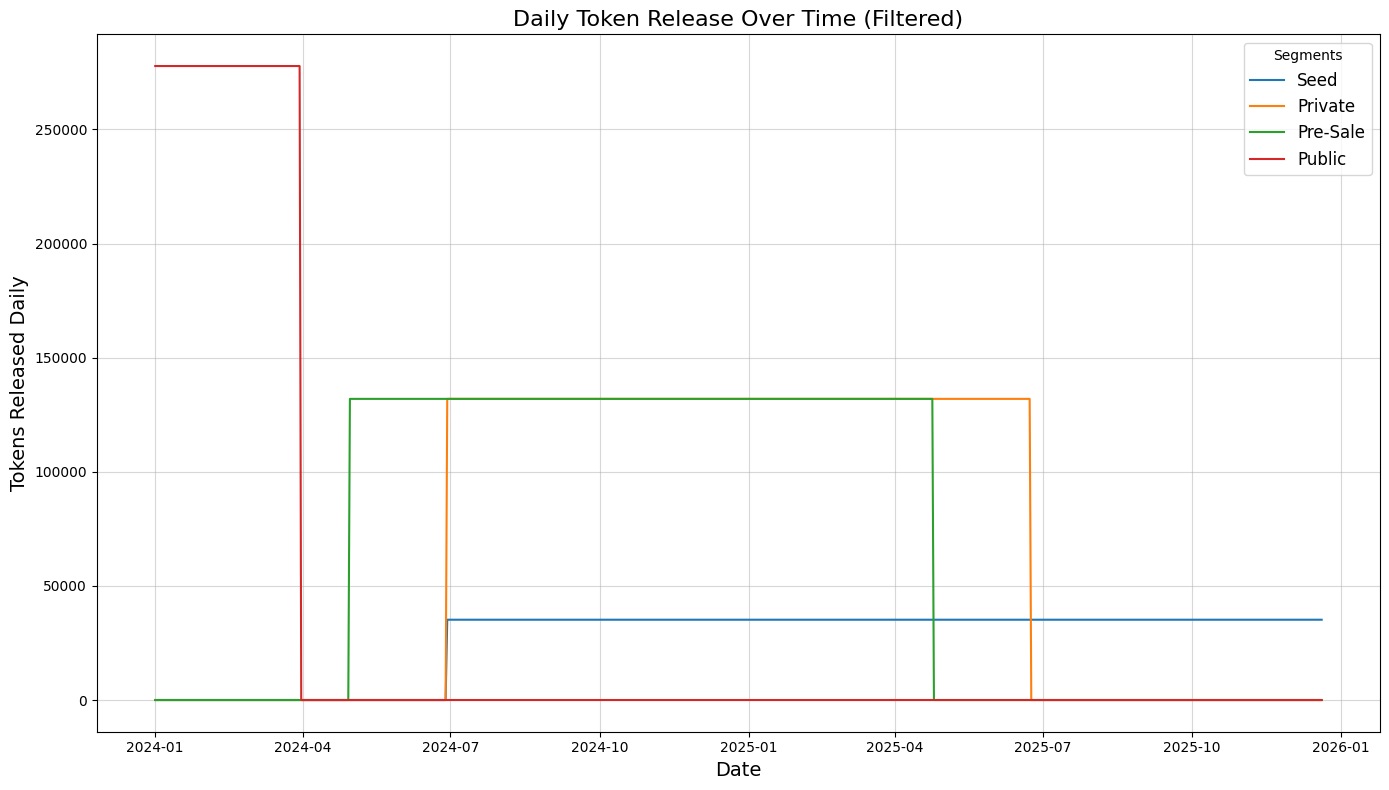

In [ ]:
def plot_daily_release_lines_clean(schedule):
    plt.figure(figsize=(14, 8))
    for column in schedule.columns:
        if "Daily" in column:
            active_data = schedule[column].dropna()  # Drop NaN values
            plt.plot(active_data.index, active_data, label=column.split("(")[0])

    plt.title("Daily Token Release Over Time (Filtered)", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Tokens Released Daily", fontsize=14)
    plt.legend(title="Segments", fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_daily_release_lines_clean(schedule_df)


In [ ]:
import plotly.graph_objects as go

def plotly_filtered_daily_release(schedule):
    fig = go.Figure()
    for column in schedule.columns:
        if "Daily" in column:
            active_data = schedule[column].dropna()  # Remove NaN values
            fig.add_trace(
                go.Scatter(
                    x=active_data.index,
                    y=active_data,
                    mode="lines",
                    name=column.split("(")[0]
                )
            )
    fig.update_layout(
        title="Filtered Daily Token Release (Interactive)",
        xaxis_title="Date",
        yaxis_title="Tokens Released Daily",
        legend_title="Segments",
        template="plotly_white",
        width=1000,
        height=600
    )
    fig.show()

plotly_filtered_daily_release(schedule_df)


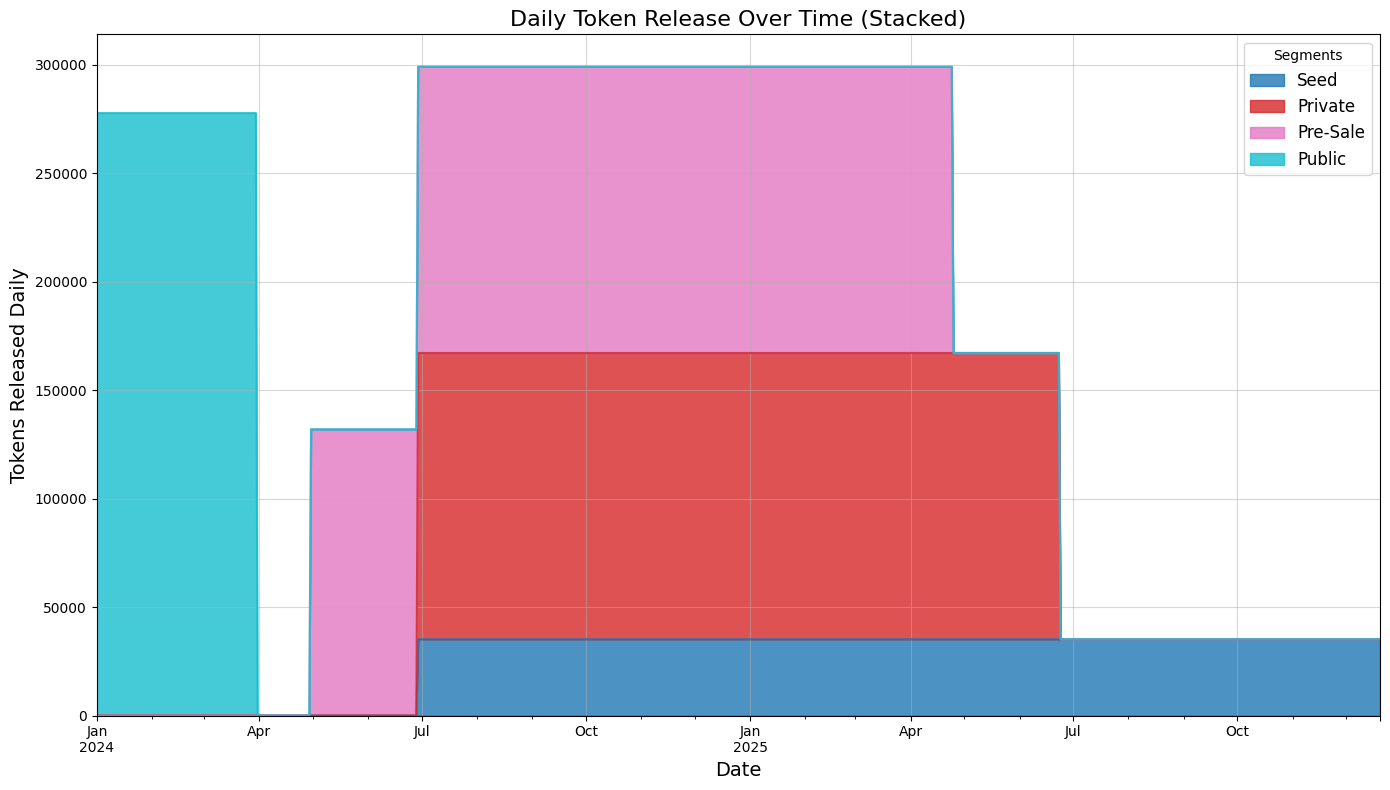

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt # Import the matplotlib library

def plot_daily_release_area(schedule):
    daily_data = schedule[[col for col in schedule.columns if "Daily" in col]]
    daily_data.columns = [col.split("(")[0] for col in daily_data.columns]  # Clean column names

    daily_data.plot(
        kind="area",
        stacked=True,
        figsize=(14, 8),
        alpha=0.8,
        colormap="tab10"
    )
    plt.title("Daily Token Release Over Time (Stacked)", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Tokens Released Daily", fontsize=14)
    plt.legend(title="Segments", fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Generate and plot the daily release (stacked area)
plot_daily_release_area(schedule_df)

In [ ]:
import plotly.graph_objects as go

def plotly_daily_release(schedule):
    fig = go.Figure()
    for column in schedule.columns:
        if "Daily" in column:
            fig.add_trace(
                go.Scatter(
                    x=schedule.index,
                    y=schedule[column],
                    mode="lines",
                    stackgroup="one",  # For stacked area chart
                    name=column.split("(")[0]
                )
            )
    fig.update_layout(
        title="Daily Token Release Over Time (Interactive Stacked Area)",
        xaxis_title="Date",
        yaxis_title="Tokens Released Daily",
        legend_title="Segments",
        template="plotly_white",
        width=1000,
        height=600
    )
    fig.show()

# Plot interactive daily release
plotly_daily_release(schedule_df)



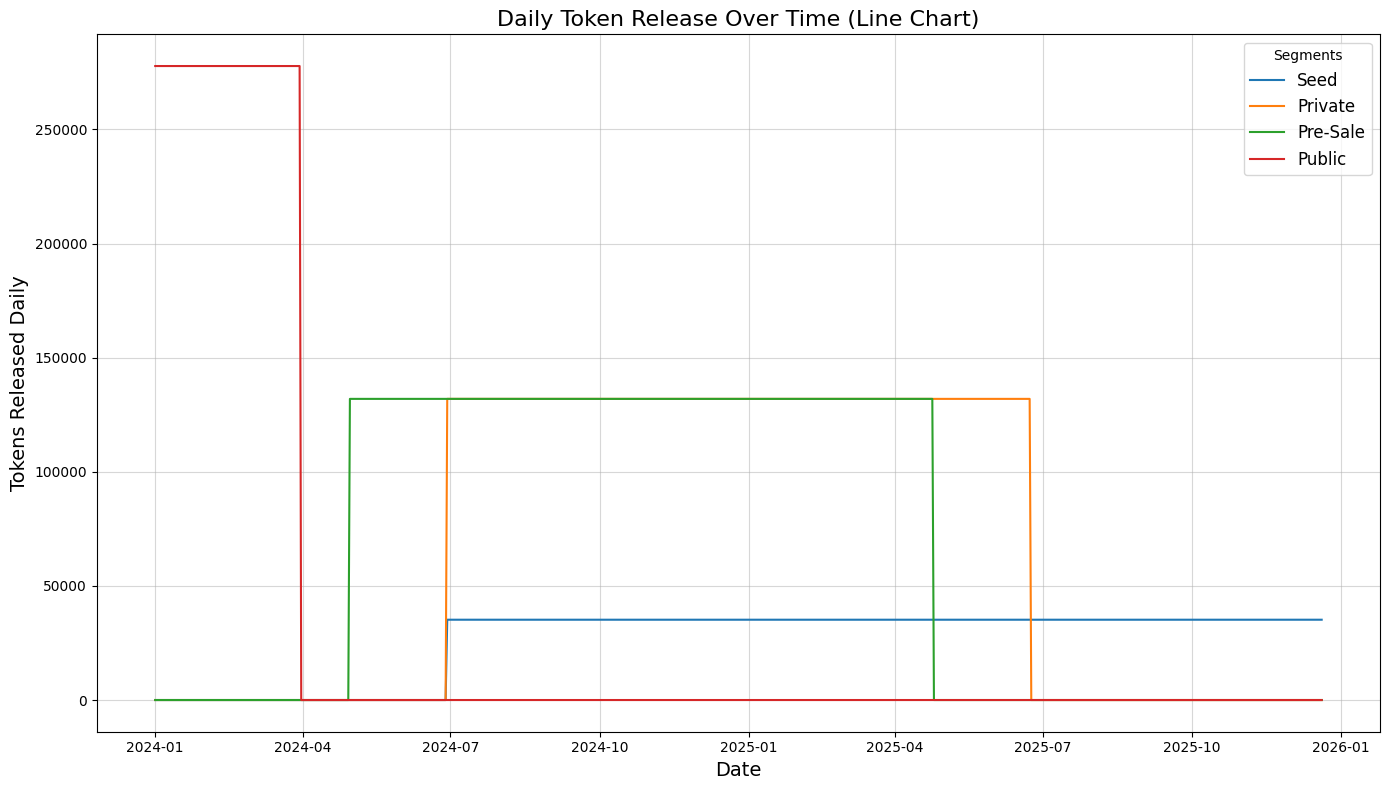

In [ ]:
def plot_daily_release_lines(schedule):
    plt.figure(figsize=(14, 8))
    for column in schedule.columns:
        if "Daily" in column:
            plt.plot(schedule.index, schedule[column], label=column.split("(")[0])

    plt.title("Daily Token Release Over Time (Line Chart)", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Tokens Released Daily", fontsize=14)
    plt.legend(title="Segments", fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot daily release as line chart
plot_daily_release_lines(schedule_df)


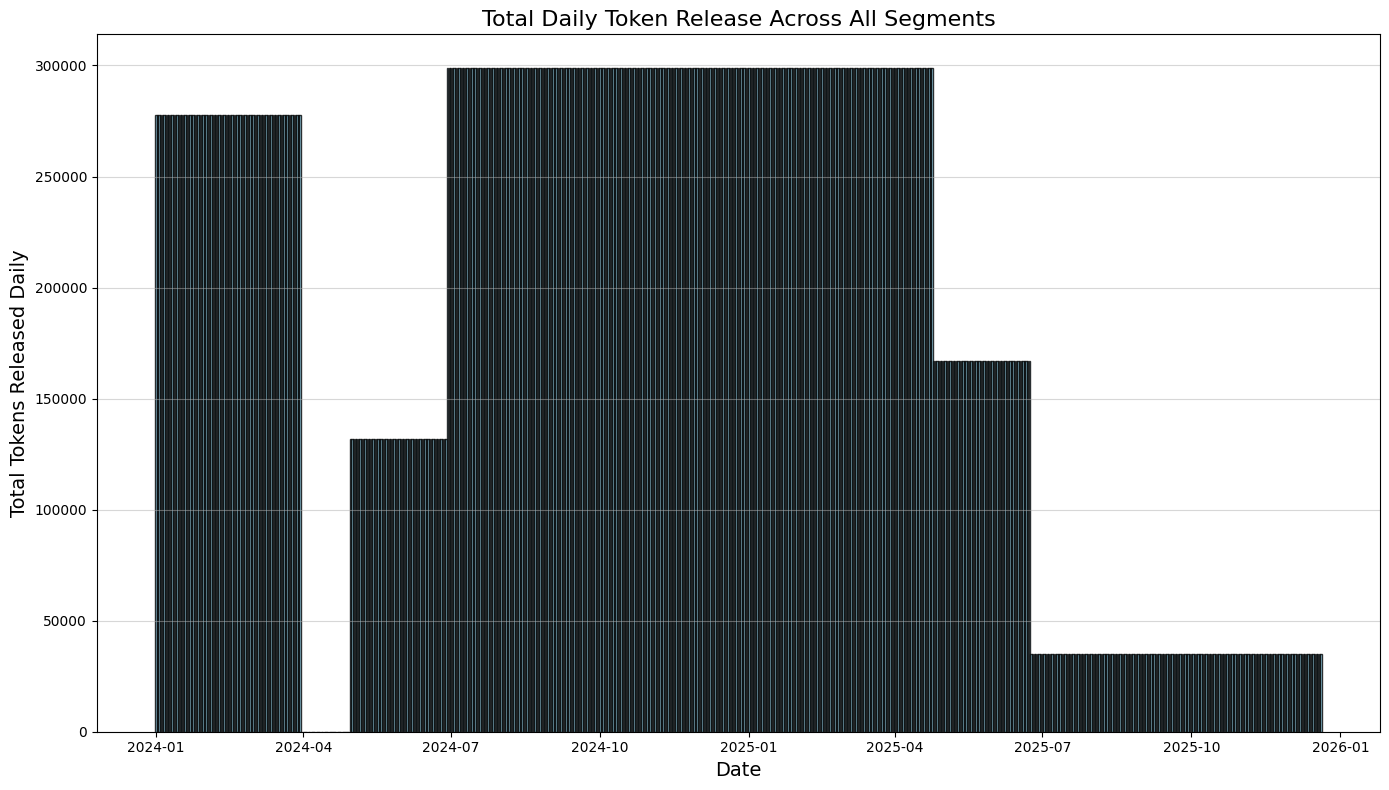

In [ ]:
def plot_total_daily_release(schedule):
    daily_totals = schedule[[col for col in schedule.columns if "Daily" in col]].sum(axis=1)

    plt.figure(figsize=(14, 8))
    plt.bar(daily_totals.index, daily_totals.values, color="skyblue", edgecolor="black", alpha=0.8)
    plt.title("Total Daily Token Release Across All Segments", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Total Tokens Released Daily", fontsize=14)
    plt.grid(alpha=0.5, axis="y")
    plt.tight_layout()
    plt.show()

# Plot total daily releases
plot_total_daily_release(schedule_df)
